## Import

In [ ]:
import os, sys, inspect, time

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import discrepancy, visualization
from algorithms import ABC_algorithms, SMCABC, SMC2ABC, SNLABC, SNL2ABC
from problems import problem_GK

import utils_os, utils_math

%load_ext autoreload
%autoreload 2

## Problem Definition

In [ ]:
DIR = 'results/GK'                                             
RERUN = not utils_os.is_file_exist(DIR, 'true_samples.npy') 

## Define the problem
problem = problem_GK.GK_Problem(N=200, n=50)
true_theta = problem.get_true_theta()

## Get x_o ~ p(x|theta)
if RERUN:
    # observed data x_o
    problem.data_obs = problem.simulator(true_theta)
    problem.y_obs = problem.statistics(data=problem.data_obs, theta=true_theta)
    utils_os.save_object(DIR, 'data_obs', problem.data_obs)
    utils_os.save_object(DIR, 'y_obs', problem.y_obs)
    problem.train_inversion_net()
    torch.save(problem.invnet.state_dict(), '{}/invnet.model'.format(DIR))
    problem.invnet.load_state_dict(torch.load('{}/invnet.model'.format(DIR)))
    problem.test_inversion_net()
    
    # true samples theta ~ pi(theta|x_o)
    true_samples = problem.sample_from_true_posterior()
    utils_os.save_object(DIR, 'true_samples', true_samples)
else:
    problem.data_obs  = utils_os.load_object(DIR, 'data_obs.npy')
    problem.y_obs  = utils_os.load_object(DIR, 'y_obs.npy')
    problem.invnet.load_state_dict(torch.load('{}/invnet.model'.format(DIR)))
    problem.test_inversion_net()
    
    # load previously simulated true samples & x_o
    true_samples = utils_os.load_object(DIR, 'true_samples.npy')
    problem.data_obs  = utils_os.load_object(DIR, 'data_obs.npy')
    problem.y_obs  = utils_os.load_object(DIR, 'y_obs.npy')
    
## Visualize
t0 = time.time()  
problem.visualize()
visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,1))
plt.savefig('{}/GK_true_posterior01.png'.format(DIR))
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,2))
# plt.savefig('{}/GK_true_posterior02.png'.format(DIR))
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(1,2))
# plt.savefig('{}/GK_true_posterior12.png'.format(DIR))
t1 = time.time()
problem.time_used = (t1 - t0)
print('time used=', t1-t0)

/home/ubuntu/research/nde_lfi/problems/problem_GK.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X).float()
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/ubuntu/research/nde_lfi/problems/problem_GK.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g,k = torch.tensor(g).float(), torch.tensor(k).float()
/home/ubuntu/research/nde_lfi/problems/problem_GK.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach(

z= tensor([-1.2402,  1.2585, -0.9433])
z_rec= tensor([-1.2407,  1.2576, -0.9438], grad_fn=<ViewBackward>)
loss(z).mean= 0.0014352340949699283
loss(z).max= 0.014043211936950684
x= tensor([1.0734, 3.6307, 1.8946])
x_rec= tensor([1.0733, 3.6273, 1.8942], grad_fn=<ViewBackward>)
loss(x).mean= 0.005666833836585283
loss(x).max= 0.11130142211914062
p(x)=


mean-parma1 =  2.9082355743784003      mean-param2 =  0.24475700604055553
shape= (100, 3)


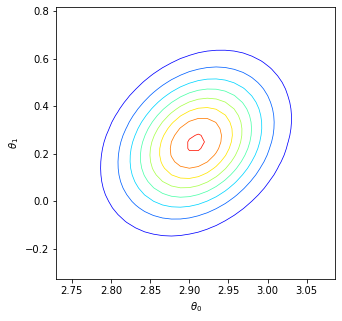

In [38]:
problem.fit_approx_likelihood(true_samples)
visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_approx_likelihood, dimensions=(0,1))
plt.savefig('{}/GK_gaussian_approx01.png'.format(DIR))
samples = problem.sample_approx_likelihood(n=100).shape
print('shape=', samples)

In [55]:
JSD = discrepancy.JSD(problem.log_likelihood, problem.log_approx_likelihood, problem.log_approx_likelihood, problem.sample_approx_likelihood(1000))
print('JSD=', JSD)

JSD= 0.346573590279969


## Inference

### SMC-ABC

In [ ]:
## Sequential Monte Carlo ABC

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cpu'
hyperparams.num_sim = 4000                        # number of simulations
hyperparams.num_samples = 200                     # number of samples to represent posterior
hyperparams.L = 2                                 # number of rounds in sequential learning

smc_abc = SMCABC.SMC_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc_abc.run()

JSD_smc_array = []
for l in range(hyperparams.L):
    print('round =', l)
    smc_abc.posterior = smc_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc_array.append(JSD)
    print('JSD smc = ', JSD)
utils_os.save_object(DIR, 'JSD_SMC', JSD_smc_array)

In [ ]:
## Sequential Monte Carlo ABC +

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cpu'
hyperparams.num_sim = 4000                       # number of simulations
hyperparams.num_samples = 200                    # number of samples to represent posterior
hyperparams.L = 2                                # number of learning rounds
hyperparams.hidden_ratio = 0.10                  # dimensionality of S(x)
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.estimator = 'JSD'                    # MI estimator; JSD (accurate) or DC (fast)

smc2_abc = SMC2ABC.SMC2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc2_abc.run()

JSD_smc2_array = []
for l in range(len(smc2_abc.posterior_array)):
    print('l=', l)
    smc2_abc.l = l
    smc2_abc.posterior = smc2_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc2_array.append(JSD)
    print('JSD smc2 = ', JSD)
utils_os.save_object(DIR, 'JSD_SMC2', JSD_smc2_array)

### SNL

In [ ]:
## Sequential Neural Likelihood
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cpu'
hyperparams.num_sim = 4000
hyperparams.L = 2

print('\n SNL ABC')
snl_abc = SNLABC.SNL_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl_abc.run()

JSD_array = []
for l in range(len(snl_abc.nde_array)):
    print('l=', l)
    snl_abc.nde_net = snl_abc.nde_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl = ', JSD)
utils_os.save_object(DIR, 'JSD_SNL', JSD_array)

iteration  0
# of cpus =  4
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[sampling] finished sampling  500
[sampling] finished sampling  1000
[sampling] finished sampling  1500
[sampling] finished sampling  2000

 > fitting encoder
summary statistic dim = 6 original dim = 21
architecture [21, 100, 100, 6]
validation size= 0.85
finished: t= 0 loss= -0.9864823818206787 loss val= -0.9865646958351135 time= 0.006151046071733747
finished: t= 50 loss= -0.9940373301506042 loss val= -0.9931756258010864 time= 0.0051550524575369695
finished: t= 100 loss= -0.9942624568939209 loss val= -0.9933565855026245 time= 0.0052285534994942805
finished: t= 150 loss= -0.9944977164268494 loss val= -0.9935599565505981 time= 0.005654142016456241
finished: t= 200 loss= -0.9934532642364502 loss val= -0.9935498237609863 time= 0.005188453765142532
finished: t= 250 loss= -0.9944650530815125 loss val= -0.9936448931694031 time= 0.004788041114807129
finished: t= 300 

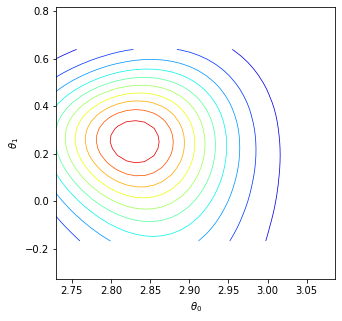

In [58]:
### Sequential Neural Likelihood + 
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cpu'
hyperparams.num_sim = 10000                      # number of simulations
hyperparams.L = 1                                # number of learning rounds
hyperparams.hidden_ratio = problem.K*2           # dimensionality of S(x)
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.stat_type = 'infomax'                # use infomax statistics
hyperparams.estimator = 'DC'                     # MI estimator; JSD (accurate) or DC (fast)
hyperparams.nde = 'MAF'                          # nde; MAF (D>1) or MDN (D=1)

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl2_abc.run()

JSD_array = []
for l in range(len(snl2_abc.nde_array)):
    print('l=', l)
    snl2_abc.set(l=l)
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl2_abc.log_likelihood, dimensions=(0,1))
    plt.savefig('{}/GK_approx_posterior01.png'.format(DIR))
    JSD = discrepancy.JSD(problem.log_likelihood, snl2_abc.log_likelihood, true_samples, true_samples, N_grid=20)
    JSD_array.append(JSD)
    print('JSD snl+ = ', JSD)
utils_os.save_object(DIR, 'JSD_SNL2', JSD_array)

iteration  0
# of cpus =  4
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[sampling] finished sampling  100
[sampling] finished sampling  200
[sampling] finished sampling  300
[sampling] finished sampling  400

 > fitting encoder
summary statistic dim = 3 original dim = 21
architecture [21, 100, 100, 3]
finished: t= 0 loss= 11.537718772888184 loss val= 11.128609657287598
finished: t= 400 loss= 1.1048266887664795 loss val= 1.1361781358718872
finished: t= 800 loss= 1.1419142484664917 loss val= 1.121345043182373
finished: t= 1200 loss= 0.36443570256233215 loss val= 0.39303916692733765
finished: t= 1600 loss= 0.36455968022346497 loss val= 0.3729495704174042
best val loss= 0.3654721975326538

 > fitting nde
all_stats.size() torch.Size([2000, 3])
finished: t= 0 loss= 7.374903678894043 loss val= 6.793354034423828
best val loss= -5.431980133056641


l= 0
mean-parma1 =  2.9082355743784003      mean-param2 =  0.24475700604055553


KeyboardInterrupt: 

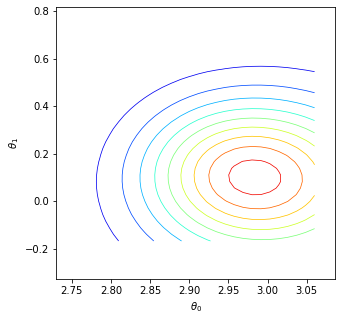

In [17]:
### Sequential Neural Likelihood '
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cpu'
hyperparams.num_sim = 2000                       # number of simulations
hyperparams.L = 1                                # number of learning rounds
hyperparams.hidden_ratio = problem.K             # dimensionality of S(x); here it equals to dim(theta)
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.stat_type = 'moment'                 # use posterior moment as statistics
hyperparams.nde = 'MAF'                          # nde; MAF (D>1) or MDN (D=1)

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl2_abc.run()

JSD_array = []
for l in range(len(snl2_abc.nde_array)):
    print('l=', l)
    snl2_abc.set(l=l)
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl2_abc.log_likelihood, problem.log_approx_likelihood, problem.sample_approx_likelihood(1000))
    JSD_array.append(JSD)
    print('JSD snl+ = ', JSD)
utils_os.save_object(DIR, 'JSD_SNL2', JSD_array)